s0Label = 18
t0Label = 19
sStarLael = 20
tStarLael = 21
Gesamtanzahl Transkripte:  0
0.097s


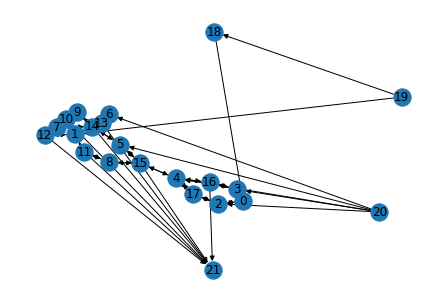

In [1]:
# IMPORT
import sys
import parse_graph_new
import path_enumeration
import pairedbin_enumeration
import networkx as nx
import time
import matplotlib.pyplot as plt
from copy import deepcopy 
import optimize
from flowProblem import writeGStar

# VARIABLES
start = time.time()
no_trans = 0
#gene_id = 0
#file_gtf = open("transcripts.gtf", "w") 

# MAIN
with open('test2.graph') as f:
    fileEndReached = False
    f.readline() #skip ---- seperator line
    while not fileEndReached:
        
        # READ META AND BIN DATA FROM FILE
        f.readline() #skip ==META 
        Chromosome, Strand, Exons = parse_graph_new.parse_meta(f)
        Bins = parse_graph_new.parse_bins(f)
        PairedBins = parse_graph_new.parse_pairs(f)
        PairedBins_copy = deepcopy(PairedBins)

        # BUILD GRAPH
        G_full = nx.DiGraph()
        fileEndReached, skip = parse_graph_new.parse_graph(f, G_full, Exons)

        if not fileEndReached and not skip:
            G_clean = nx.DiGraph()
            fileEndReached, _ = parse_graph_new.parse_graph(f, G_clean, Exons)
            # nx.draw_networkx(G_clean, with_labels=True, arrowsize=12)
            # plt.show()
        if skip:
            G_clean = G_full

        transcripts = []
        writeGStar(G_full)

        # FULL PATH ENUMERATION
        """
        transcripts = path_enumeration.enumeration(G_full,[],"0",["0"],"1",True)
        no_trans = no_trans + len(transcripts)
        """
        
        # MULTI BIN ENUMERATION
        """
        multi_bins = path_enumeration.get_multibins(Bins)
        transcripts = path_enumeration.enumeration_bins2(G_clean,[],"0",["0"],[],multi_bins,"1",True)
        no_trans = no_trans + len(transcripts)
        """
        
        # PAIRED BIN ENUMERATION 1
        """
        multi_bins = path_enumeration.get_multibins(Bins)
        paired_bins = pairedbin_enumeration.get_pairedbins(G_clean,PairedBins_copy,multi_bins)
        transcripts = path_enumeration.enumeration_bins2(G_clean,[],"0",["0"],[],paired_bins+multi_bins,"1",True)
        no_trans = no_trans + len(transcripts)
        """
        
        # PAIRED BIN ENUMERATION 2
        """
        pairedbins_grouped = pairedbin_enumeration.group_pairs(PairedBins_copy)
        multi_bins = path_enumeration.get_multibins(Bins)
        transcripts = path_enumeration.enumeration_bins2(G_clean,[],"0",["0"],[],multi_bins,"1",True)
        transcripts_copy = deepcopy(transcripts)
        filtered_transcripts = pairedbin_enumeration.filter_transcripts(transcripts_copy,pairedbins_grouped)
        no_trans = no_trans + len(filtered_transcripts)
        """
        
        # ADD TRANSCRIPTS TO GTF FILE
        """
        gene_id += 1
        transcript_id = 0
        for transcript in transcripts:
            transcript_id += 1
            parse_graph_new.write_valid_gtf_entry(file_gtf,Chromosome,Strand,Exons,transcript,"Gene"+str(gene_id),"Transcript"+str(transcript_id))
        """
    
        # Optimization 
        """
        transcripts = path_enumeration.enumeration(G_clean, [], "0", ["0"], "1", False)
        print(optimize.model(G_clean, transcripts))
        #get dictionary with expression levels (F=(f1,f2,f3,...fN))
        var_dict = optimize.model(G_clean, transcripts)
        """


    # PRINT RESULTS  
    end = time.time()
    print("Gesamtanzahl Transkripte: ", no_trans)
    print('{:5.3f}s'.format(end-start))       
    #file_gtf.close()
